In [17]:
import numpy as np
from scipy import linalg as la
from scipy.linalg import norm
import pywt
from scipy.linalg import solve_triangular
from scipy import sparse
import matplotlib.pyplot as plt

# import matplotlib # used in slurm
# matplotlib.use('agg')
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams["figure.figsize"] = (20,10)
%load_ext memory_profiler 
# Running this notebook may require large memory (>2G per cpu)!

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler


In [18]:
def ista(X, y, lam, L, b0, maxiter=100):
    """ 
    Solve Lasso via ISTA (Iterative Shrinkage-Thresholding Algorithm)
    
    Parameters
    ----------
    X: design matrix, array_like, shape (n, 2)
    y: response vector, array_like, shape (n, )
    lam: regularization parameter, scalar
    L: Lipschitz constant of the quadratic form 
    b0: initialization of the coefficient vector

    Returns
    -------
    B: estimated coefficient vectors, shape (p, maxiter+1), with 1st column b0
    
    """
    b = b0.copy()
    n, p = X.shape
    B = np.zeros((p, maxiter+1))
    B[:,0] = b0
    for i in range(maxiter):
        z = b + 1/(n*L) * X.T @ (y - X@b) # forward(explicit) step
        b = pywt.threshold(z, lam/L, 'soft') # backward(implicit) step
        B[:,i+1] = b
    return B

def fista(X, y, lam, L, b0, maxiter=100):
    """ 
    Solve Lasso via FISTA (Fast Iterative Shrinkage-Thresholding Algorithm)
    
    Parameters
    ----------
    X: design matrix, array_like, shape (n, 2)
    y: response vector, array_like, shape (n, )
    lam: regularization parameter, scalar
    L: Lipschitz constant of the quadratic form 
    b0: initialization of the coefficient vector

    Returns
    -------
    B: estimated coefficient vectors, shape (p, maxiter+1), with 1st column b0
    vec1: 1st off diagonal vector (useful for estimating errors), shape (p*maxiter, )
    vec2: 2nd off diagonal vector (useful for estimating errors), shape (p*maxiter, )
    
    """
    b = b0.copy()
    u = b0.copy()
    n, p = X.shape
    t = 1.0
    B = np.zeros((p, maxiter+1))
    B[:,0] = b0
    vec1 = []
    vec2 = []
    for i in range(maxiter):
        uold = u
        # soft-thresholding 
        u = pywt.threshold(b + 1/(n*L) * X.T @ (y - X@b), lam/L, 'soft')
        told = t
        t = (1 + np.sqrt(1 + 4*t*t)) / 2
        w = (told - 1) / t
        b = u + w * (u - uold)
        B[:,i+1] = b 

        vec1 = np.append(vec1, (1+w)*(u!=0))   # 1st off diagonal
        t_new = (1 + np.sqrt(1 + 4*t*t)) / 2
        w_new = (t - 1) / t_new 
        vec2 = np.append(vec2, -w_new *(u!=0)) # 2nd off diagonal
    return [B, vec1, vec2]

In [19]:
n, p, T = 200, 400, 20
snr = 100

rng = np.random.RandomState()
X = rng.randn(n, p)
b = np.zeros(p); b[:10] = 1
sigma = 0.5
b = b /norm(b) * sigma * snr**(.5)
B_true = np.array([b] * T).T # replicate coefficient vector b for T times

I_T = np.eye(T)
I_n = np.eye(n)
I_p = np.eye(p)

lam = 0.1 # turning parameter for lasso

In [20]:
def onerun(seed):
    rng = np.random.RandomState(seed)
    X = rng.randn(n, p)
    # b is fixed across simulations
    y = X @ b + sigma * rng.randn(n)
    
    # ISTA 
    L = norm(X, ord=2)**2 / n # Lipschitz constant
    b0 = np.zeros(p)
    
#     # ISTA
#     B_hat = ista(X, y, lam, L, b0, maxiter=T-1) # shape (p, T), first column is initialization
#     D = np.zeros((p*T, p*T))
#     flag = (np.ravel(B_hat[:,1:].T)!=0) + 0 
#     D[p:, :(p*(T-1))] = np.diag(flag)

    # FISTA
    out = fista(X, y, lam, L, b0, maxiter=T-1)
    B_hat = out[0]
    v1 = out[1] # 1st off diagonal
    v2 = out[2][:p*(T-2)]  # 2nd off diagonal
    D1 = np.diag(v1,-p)
    D2 = np.diag(v2, -2*p)
    D = D1 + D2
    
    Y = np.array([y] * T).T # replicate response vector y for T times
    H = B_hat - B_true
    F = Y - X @ B_hat
    
    
    X1 = I_p - X.T @ X / (n*L)
    D_s = sparse.csr_matrix(D)
    C = D_s @ sparse.kron(sparse.dia_matrix(I_T), X1)
    A1 = np.eye(p*T) - C.toarray()
    M = solve_triangular(A1, D, lower=True) / (n*L) # shape (pT, pT)

    # faster!!!
    N = np.zeros((n*T, n*T))
    for t in range(T):
        for t1 in range(T):
            N[t*n:(t+1)*n,t1*n:(t1+1)*n] = X @ M[t*p:(t+1)*p,t1*p:(t1+1)*p] @ X.T
    # temp = np.kron(I_T, X)
    # N = temp @ M @ temp.T

    # interaction matrix: using einsum is much faster!!!
    N1 = N.reshape((T, n, T, n))
    A = np.einsum('tiTi -> tT', N1)
    
    # generalization error
    factor = la.inv(I_T - A/n)
    gen = np.diag(H.T @ H + sigma**2 * np.ones((T,T)))
    gen_est = np.diag(n**(-1) * factor @ F.T @ F @ factor.T)

    # out-of-sample error
    out = np.diag(H.T @ H)
    temp = F.T @ X @ X.T @ F + A @ F.T @ F + F.T @ F @ A.T - p * F.T @ F
    out_est = np.diag(n**(-2) * factor @ temp @ factor.T)

    return([out, out_est, gen, gen_est])
    
# a = onerun(1) # list of length 4

In [21]:
%%time
%memit a = onerun(1)

peak memory: 2042.20 MiB, increment: 1738.62 MiB
CPU times: user 26 s, sys: 37.7 s, total: 1min 3s
Wall time: 7.08 s


In [22]:
%%time
rep = 100
from joblib import Parallel, delayed
output = Parallel(n_jobs=10, verbose=10)(
    delayed(onerun)(seedid)
    for seedid in range(rep))
output = np.array(output)
Out = output[:,0,:]         # out-of-sample error 
Out_est = output[:,1,:]     # estimated out-of-sample error 
Gen = output[:,2,:]         # generalization error 
Gen_est = output[:,3,:]     # estimated generalization error 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:   12.5s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   22.1s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   32.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   34.3s
[Parallel(n_jobs=10)]: Done  41 tasks      | elapsed:   52.9s
[Parallel(n_jobs=10)]: Done  52 tasks      | elapsed:  1.1min
[Parallel(n_jobs=10)]: Done  65 tasks      | elapsed:  1.3min
[Parallel(n_jobs=10)]: Done  78 tasks      | elapsed:  1.4min
[Parallel(n_jobs=10)]: Done  92 out of 100 | elapsed:  1.7min remaining:    9.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:  1.8min finished


CPU times: user 626 ms, sys: 173 ms, total: 798 ms
Wall time: 1min 47s


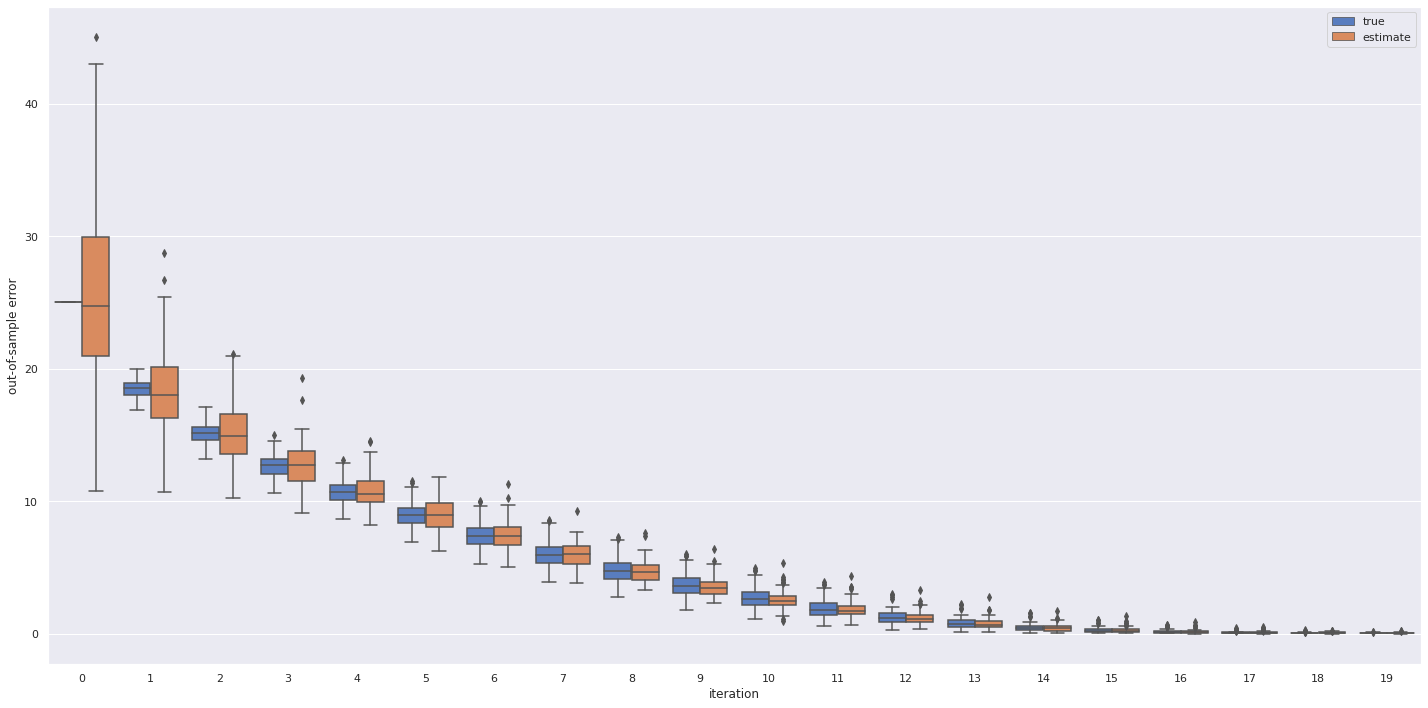

In [23]:
df1 = pd.DataFrame(np.ravel(Out.T)) # column 0
df1[1] = np.repeat(range(T), rep)   # column 1
df2 = pd.DataFrame(np.ravel(Out_est.T))
df2[1] = np.repeat(range(T), rep)
frames = [df1, df2]
df = pd.concat(frames)
df[2] = ['true']*T*rep + ['estimate']*T*rep
df.columns = ['error', 'iteration', 'comparison']

sns.set(style="darkgrid")
sns.set_palette(sns.color_palette('muted'))
sns_plot = sns.boxplot(x='iteration', y='error', hue='comparison', data=df)
sns_plot.set(xlabel='iteration', ylabel ='out-of-sample error')
plt.legend(title='')
plt.tight_layout()
fname = f'FISTA_out_n{n}_p{p}_rep{rep}.pdf'
sns_plot.figure.savefig(fname)

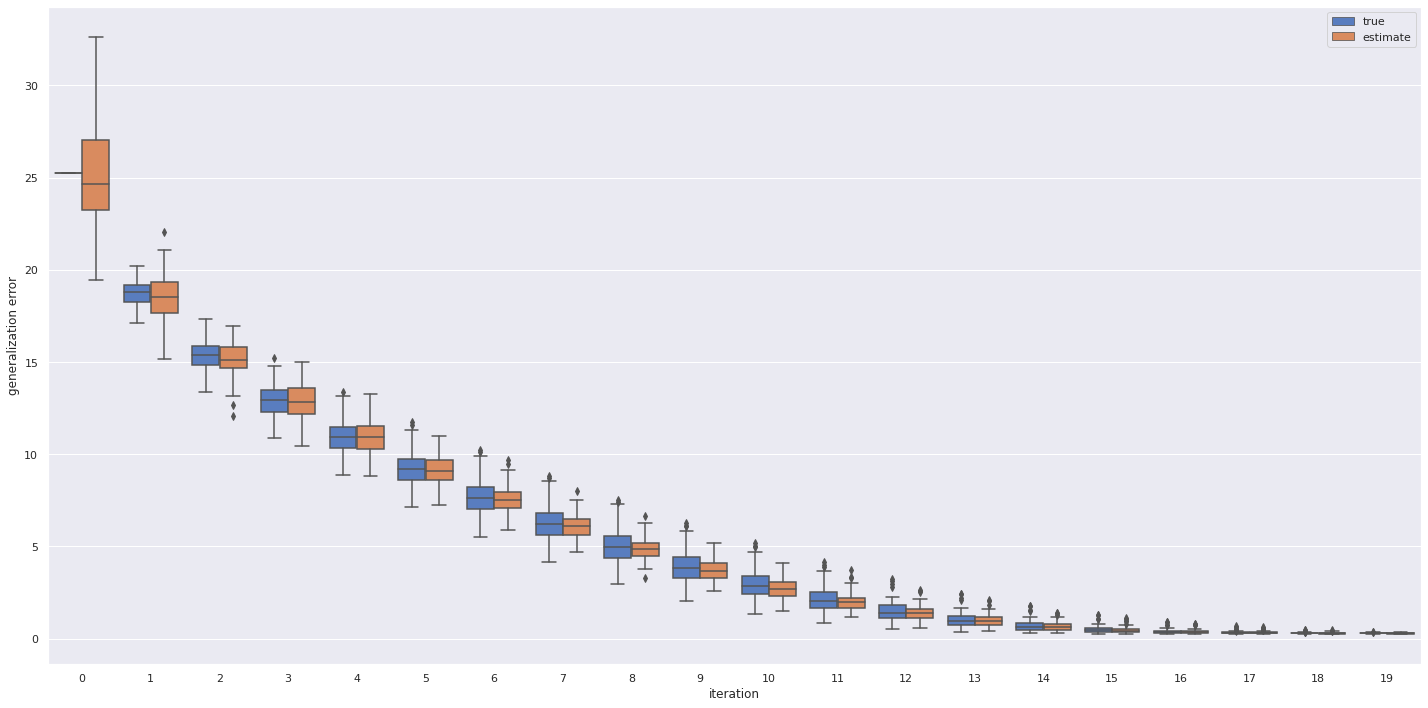

In [24]:
df1 = pd.DataFrame(np.ravel(Gen.T)) # column 0
df1[1] = np.repeat(range(T), rep)   # column 1
df2 = pd.DataFrame(np.ravel(Gen_est.T))
df2[1] = np.repeat(range(T), rep)
frames = [df1, df2]
df = pd.concat(frames)
df[2] = ['true']*T*rep + ['estimate']*T*rep
df.columns = ['error', 'iteration', 'comparison']

sns.set(style="darkgrid")
sns.set_palette(sns.color_palette('muted'))
sns_plot = sns.boxplot(x='iteration', y='error', hue='comparison', data=df)
sns_plot.set(xlabel='iteration', ylabel ='generalization error')
plt.legend(title='')
plt.tight_layout()
fname = f'FISTA_gen_n{n}_p{p}_rep{rep}.pdf'
sns_plot.figure.savefig(fname)